<a href="https://colab.research.google.com/github/Gautam-Chauhan/MAPS-Internship-Code/blob/main/object_detection_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection Inference with TensorFlow Model Garden

This notebook uses my fine-tuned object detection model to detect trash in images of the streets and drainage canals in the city of Quelimane in Mozambique.

Based on the following tutorial:

https://www.tensorflow.org/tfmodels/vision/object_detection

### PRELIMINARIES

#### Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Install packages

The following cell will install a new version of NumPy, restart the session when prompted after running this cell:

In [1]:
# Uninstall the current numpy version to avoid conflicts
!pip uninstall -y numpy
# Install a numpy version compatible with TensorFlow
!pip install numpy==1.26.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [1]:
# Install tf-models-official, ensuring compatibility with the installed numpy and TensorFlow versions
!pip install -U -q "tf-models-official"

#### Import relevant libraries

In [1]:
import os
import io
import pprint
import tempfile
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from six import BytesIO
import time
import cv2
import csv
import glob

In [2]:
import orbit
import tensorflow_models as tfm

from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import normalize_image
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

pp = pprint.PrettyPrinter(indent=4) # Set Pretty Print Indentation
print(tf.__version__) # Check the version of tensorflow used

%matplotlib inline

2.19.0


#### Set paths to files in drive

In [3]:
model_dir = '/content/drive/MyDrive/Object_Detection/FINAL'
export_dir ='/content/drive/MyDrive/Object_Detection/FINAL_export'

#### Load trained model from google drive

In [4]:
imported = tf.saved_model.load(export_dir)
model_fn = imported.signatures['serving_default']

### VISUALISE TEST IMAGES AND PREDICTIONS

The following code is for visualising some of the ground truth bounding boxes and predictions for the test images.

This does NOT need to be run if you want to do inference on some data.

In [5]:
test_data_input_path = '/content/drive/MyDrive/Object_Detection/Annotations/test.record'

#### Visualise some test images and true bounding boxes

Function to show 'num_of_examples' images from the test dataset, along with their bounding boxes:

In [12]:
category_index={
    1: {
        'id': 1,
        'name': 'Trash'
       },
}
tf_ex_decoder = TfExampleDecoder()

In [ ]:
def show_batch(raw_records, num_of_examples):
  plt.figure(figsize=(20, 20))
  use_normalized_coordinates=True
  min_score_thresh = 0.25
  for i, serialized_example in enumerate(raw_records):
    plt.subplot(1, 3, i + 1)
    decoded_tensors = tf_ex_decoder.decode(serialized_example)

    image = decoded_tensors['image'].numpy().astype('uint8')
    scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))

    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image,
        decoded_tensors['groundtruth_boxes'].numpy(),
        decoded_tensors['groundtruth_classes'].numpy().astype('int'),
        scores,
        category_index=category_index,
        use_normalized_coordinates=use_normalized_coordinates,
        max_boxes_to_draw=200,
        min_score_thresh=min_score_thresh,
        agnostic_mode=False,
        instance_masks=None,
        line_thickness=4)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Image-{i+1}')
  plt.show()

Apply the function using the test dataset:

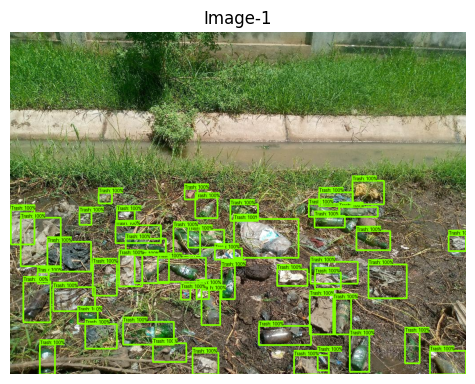

In [ ]:
num_of_examples = 1
offset = 33

test_ds = tf.data.TFRecordDataset(test_data_input_path).skip(offset).take(num_of_examples)
show_batch(test_ds, num_of_examples)

#### Visualise some test images and predicted bounding boxes

Function to resize the image so that it has the same size as for training:

In [ ]:
def build_inputs_for_object_detection(image, input_image_size):
  """Builds Object Detection model inputs for serving."""
  image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
  return image

Visualise the test images and predicted bounding boxes:

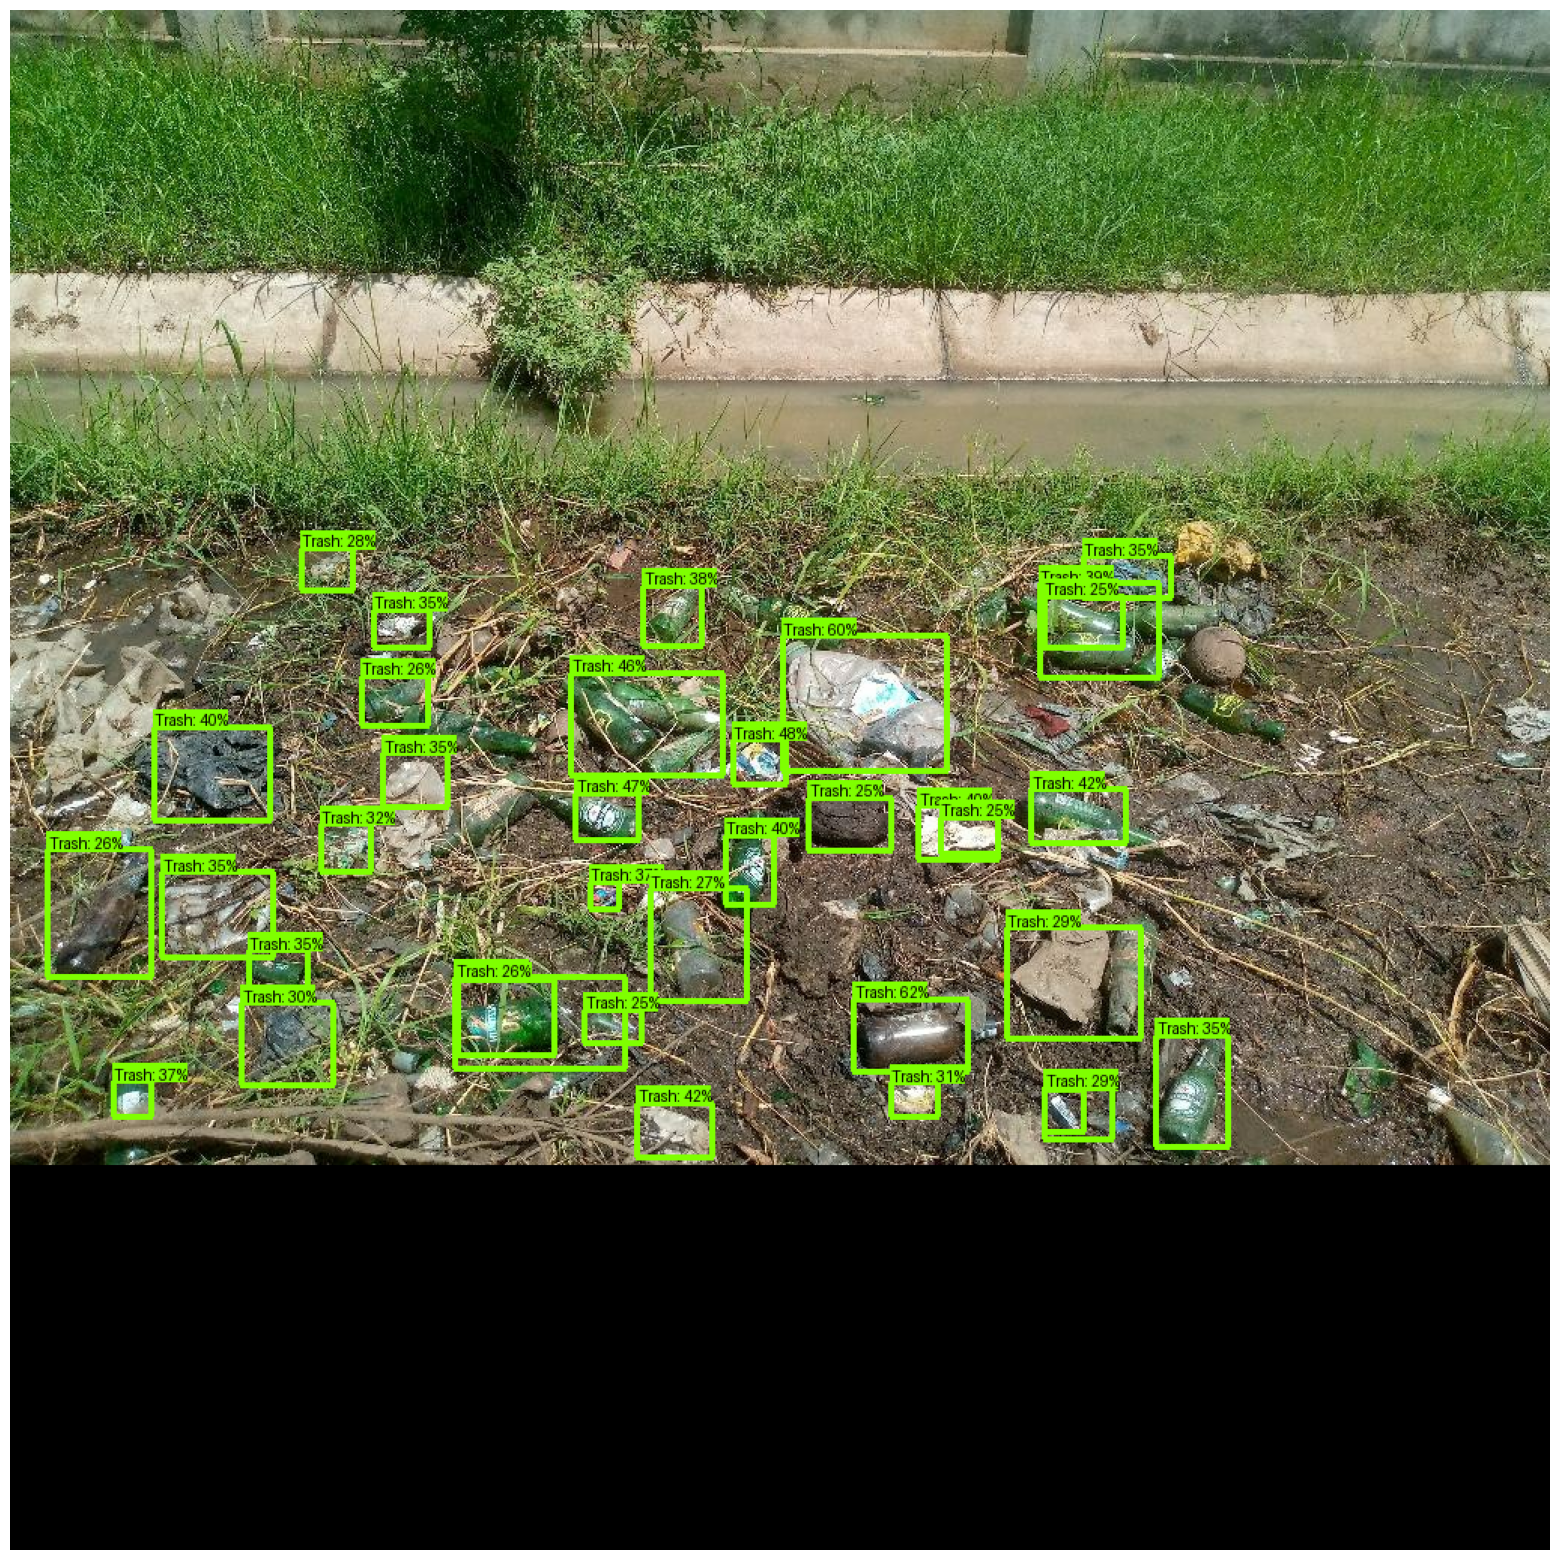

In [ ]:
# Rescale images to the size that was used for training
HEIGHT = 1024
WIDTH = 1024
input_image_size = (HEIGHT, WIDTH)
plt.figure(figsize=(20, 20))
min_score_thresh = 0.25

for i, serialized_example in enumerate(test_ds):
  plt.subplot(1, 1, i+1)
  decoded_tensors = tf_ex_decoder.decode(serialized_example)
  image = build_inputs_for_object_detection(decoded_tensors['image'], input_image_size)
  image = tf.expand_dims(image, axis=0)
  image = tf.cast(image, dtype = tf.uint8)
  image_np = image[0].numpy()
  result = model_fn(image)
  visualization_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      result['detection_boxes'][0].numpy(),
      result['detection_classes'][0].numpy().astype(int),
      result['detection_scores'][0].numpy(),
      category_index=category_index,
      use_normalized_coordinates=False,
      max_boxes_to_draw=200,
      min_score_thresh=min_score_thresh,
      agnostic_mode=False,
      instance_masks=None,
      line_thickness=4)
  plt.imshow(image_np)
  plt.axis('off')

plt.show()

#### Inference on Full Test Dataset

In [ ]:
full_test = tf.data.TFRecordDataset(test_data_input_path)

Write the images and their groundtruth boxes to a folder in my google drive:

In [ ]:
for i, serialized_example in enumerate(full_test):
  decoded_tensors = tf_ex_decoder.decode(serialized_example)

  image = decoded_tensors['image'].numpy().astype('uint8')
  scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))

  visualization_utils.visualize_boxes_and_labels_on_image_array(
      image,
      decoded_tensors['groundtruth_boxes'].numpy(),
      decoded_tensors['groundtruth_classes'].numpy().astype('int'),
      scores,
      category_index=category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=0.25,
      agnostic_mode=False,
      instance_masks=None,
      line_thickness=4)

  folder_path = '/content/drive/MyDrive/Object_Detection/test_images_true/'
  filename = str(i) + ".jpg"
  cv2.imwrite(folder_path + filename, image)

KeyboardInterrupt: 

Run inference on each example, write the predictions and ground-truth examples to a folder in my google drive, and get the number of bounding boxes.

In [ ]:
num_objects = []
true_num_objects = []
for i, serialized_example in enumerate(full_test):
  decoded_tensors = tf_ex_decoder.decode(serialized_example)
  image = build_inputs_for_object_detection(decoded_tensors['image'], input_image_size)
  image = tf.expand_dims(image, axis=0)
  image = tf.cast(image, dtype = tf.uint8)
  image_np = image[0].numpy()
  result = model_fn(image)

  # Display bounding boxes for the predictions and write them to a folder
  visualization_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      result['detection_boxes'][0].numpy(),
      result['detection_classes'][0].numpy().astype(int),
      result['detection_scores'][0].numpy(),
      category_index=category_index,
      use_normalized_coordinates=False,
      max_boxes_to_draw=200,
      min_score_thresh=0.25,
      agnostic_mode=False,
      instance_masks=None,
      line_thickness=4)
  folder_path = '/content/drive/MyDrive/Object_Detection/test_images_predictions_additional/'
  filename = str(i) + ".jpg"

  # Invert colours to format used by OpenCV
  image_np = image_np[:, :, ::-1]
  #cv2.imwrite(folder_path + filename, image_np)
  # Get the number of objects that have confidence scores > 0.25 (positive detections)
  detections = [score for score in result['detection_scores'][0].numpy() if score > 0.25]
  # Count the number of positive detections, and add it to the list for the number of objects
  num_objects.append(len(detections))
  # Get the true number of bounding boxes
  true_num_objects.append(len(decoded_tensors['groundtruth_boxes']))

Print the number of bounding boxes and the true number of bounding boxes for each image:

In [ ]:
i=0
for item in zip(num_objects, true_num_objects):
  print(str(i)+": "+str(item))
  i+=1

0: (0, 1)
1: (2, 1)
2: (7, 17)
3: (7, 12)
4: (6, 0)
5: (1, 0)
6: (6, 3)
7: (15, 16)
8: (4, 4)
9: (12, 9)
10: (0, 0)
11: (3, 2)
12: (1, 4)
13: (2, 3)
14: (6, 10)
15: (7, 9)
16: (5, 9)
17: (3, 0)
18: (10, 11)
19: (0, 0)
20: (7, 12)
21: (4, 4)
22: (5, 1)
23: (3, 0)
24: (4, 0)
25: (1, 3)
26: (21, 33)
27: (4, 2)
28: (0, 3)
29: (4, 5)
30: (2, 0)
31: (0, 1)
32: (0, 1)
33: (36, 51)
34: (0, 0)
35: (0, 0)
36: (2, 0)
37: (1, 0)
38: (1, 1)
39: (0, 0)
40: (4, 1)
41: (4, 9)
42: (1, 0)
43: (11, 30)
44: (6, 0)
45: (1, 2)
46: (0, 0)
47: (0, 0)
48: (0, 0)
49: (1, 7)
50: (9, 14)
51: (2, 0)
52: (19, 16)
53: (11, 26)
54: (0, 2)
55: (0, 0)
56: (1, 1)
57: (0, 0)
58: (2, 1)
59: (5, 2)
60: (18, 19)
61: (18, 20)
62: (0, 0)
63: (0, 3)
64: (6, 5)
65: (0, 0)
66: (6, 8)
67: (3, 1)
68: (3, 7)
69: (3, 5)
70: (10, 16)
71: (2, 2)
72: (4, 2)
73: (4, 18)
74: (1, 1)
75: (0, 0)
76: (0, 0)
77: (1, 1)
78: (0, 0)
79: (0, 0)
80: (21, 22)
81: (1, 0)
82: (0, 0)
83: (1, 2)
84: (0, 2)
85: (1, 0)
86: (1, 0)
87: (18, 26)
88: (2, 1)


### INFERENCE ON DATASET

Define important functions for the inference:

In [6]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array, so that we can make predictions
  on it using the trained model. The output array has shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return image
  #return np.array(image.getdata()).reshape(
      #(1, im_height, im_width, 3)).astype(np.uint8)


def build_inputs_for_object_detection(image, input_image_size):
  """Builds Object Detection model inputs for serving."""
  image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
  return image

Run the model on each of the unseen images and get the number of bounding boxes, and the total area of all the bounding boxes. Add them to a list, and then at the end, write the whole list to a csv file.

In [9]:
# Rescale input to size (1024,1024)
input_size = (1024,1024)
output_info = []
data_path = '/content/drive/MyDrive/Object_Detection/data_8568/'

for filepath in glob.glob(data_path + '*.jpg'):

  image = load_image_into_numpy_array(filepath)
  image = build_inputs_for_object_detection(image,input_size)
  image = tf.expand_dims(image, axis=0)
  image = tf.cast(image, dtype = tf.uint8)
  image_np = image[0].numpy()
  result = model_fn(image)

  count=0
  total_area=0
  for detection in zip(result['detection_boxes'][0].numpy(), result['detection_scores'][0].numpy()):
    if detection[1] > 0.25:
      count+=1
      box = detection[0]
      ymin = box[0]
      xmin = box[1]
      ymax = box[2]
      xmax = box[3]
      area = (ymax-ymin)*(xmax-xmin)
      total_area += area

  filename = filepath.removeprefix(data_path)
  image_dict = {'image_id':filename, 'num_detections':count, 'area_covered': total_area}
  output_info.append(image_dict)


with open(output_path, 'w', newline='') as csvfile:
  fieldnames = ['image_id','num_detections','area_covered']
  writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
  writer.writeheader()
  writer.writerows(output_info)

FileNotFoundError: [Errno 2] No such file or directory: '/content/MyDrive/Object_Detection/output_data/output_file_1'

In [10]:
# Change this path for different data files
output_dir = '/content/drive/MyDrive/Object_Detection/output_data/'
output_path = os.path.join(output_dir, 'output_file_1.csv')

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

with open(output_path, 'w', newline='') as csvfile:
  fieldnames = ['image_id','num_detections','area_covered']
  writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
  writer.writeheader()
  writer.writerows(output_info)